# Gradient boosting classifier: diabetes prediction

## 1. Data acquisition

In [1]:
# Handle imports up-front

# Standard library imports
import pickle

# PyPI imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import uniform, norm, randint
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# Internal imports
from helper_functions.random_forest import cross_val
from helper_functions.random_forest import plot_hyperparameter_tuning
from helper_functions.random_forest import plot_cross_validation

### 1.1. Load the data

In [2]:
# Load the cleaned and processed data from the decision tree notebook
data_file='../data/processed_data/diabetes_data.pkl'

with open(data_file, 'rb') as input_data:
    training_features, testing_features, training_labels, testing_labels=pickle.load(input_data)

### 1.2. Inspect the data

In [3]:
training_features.head()

,Glucose,Insulin,BMI,Age
0,115.0,87.534395,24.0,34.0
1,142.0,190.000000,28.8,61.0
2,116.0,87.000000,22.1,37.0
3,126.0,219.091519,30.1,47.0
4,78.0,105.000000,32.5,39.0


In [4]:
training_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Glucose  514 non-null    float64
 1   Insulin  514 non-null    float64
 2   BMI      514 non-null    float64
 3   Age      514 non-null    float64
dtypes: float64(4)
memory usage: 16.2 KB


In [5]:
training_labels.head()

0    0
1    0
2    0
3    1
4    0
Name: Outcome, dtype: int64

In [6]:
training_labels.info()

<class 'pandas.core.series.Series'>
RangeIndex: 514 entries, 0 to 513
Series name: Outcome
Non-Null Count  Dtype
--------------  -----
514 non-null    int64
dtypes: int64(1)
memory usage: 4.1 KB


## 2. Model optimization

In [7]:
# Start a dictionary to hold optimization experiment results
hyperparameter_experiments={}

### 2.1. Baseline model performance

In [8]:
# Instantiate a random forest classifier model
model=GradientBoostingClassifier(random_state=315)

# Run the cross-validation
scores=cross_val(model, training_features, training_labels)

# Collect the results
hyperparameter_experiments['Baseline']=scores * 100

Cross-validation accuracy: 77.22 +/- 3.39%


### 2.2. Hyperparameter optimization: loss, criterion

In [9]:
model=GradientBoostingClassifier(random_state=315)

distributions={
    'loss': ['log_loss', 'exponential'],
    'criterion': ['friedman_mse', 'squared_error']
}

# Define the cross-validation strategy
cv_method=StratifiedKFold(n_splits=7, shuffle=True, random_state=315)

grid=GridSearchCV(
    model,
    distributions,
    scoring='accuracy',
    n_jobs=-1,
    cv=cv_method,
    return_train_score=True
)

round_one_results=grid.fit(training_features, training_labels)
print(f'Best hyperparameters: {round_one_results.best_params_}')

Best hyperparameters: {'criterion': 'friedman_mse', 'loss': 'exponential'}


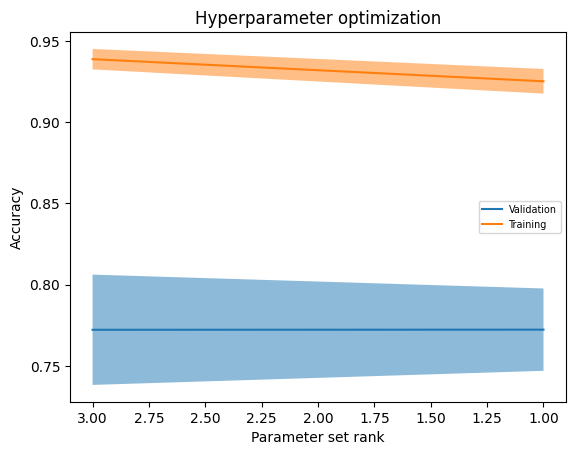

In [10]:
plot_hyperparameter_tuning(round_one_results).show()

In [11]:
# Instantiate a model using the winning parameters
model=GradientBoostingClassifier(
    **round_one_results.best_params_,
    random_state=315
)

# Run cross-validation on the best model
scores=cross_val_score(
    model,
    training_features,
    training_labels,
    cv=cv_method,
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
hyperparameter_experiments['Hyperparameter\noptimization\nround 1']=scores * 100
print(f'Cross-validation accuracy: {(np.median(scores) * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 76.7 +/- 2.5%


### 2.3. Other hyperparameters

In [12]:
# Instantiate a model using the winning parameters from the first round
# of hyperparameter optimization
model=GradientBoostingClassifier(
    **round_one_results.best_params_,
    random_state=315
)

distributions={
    'n_estimators': randint(1, 200),
    'max_depth': randint(1, 51),
    'min_samples_split': randint(2, 51),
    'min_samples_leaf': randint(1, 51),
    'min_weight_fraction_leaf': uniform(loc=0.0, scale=0.5),
    'min_impurity_decrease': uniform(loc=0.0, scale=0.5),
    'ccp_alpha': uniform(loc=0.0, scale=0.5)
}

grid=RandomizedSearchCV(
    model,
    distributions,
    scoring='accuracy',
    n_jobs=-1,
    cv=cv_method,
    n_iter=500,
    random_state=315,
    return_train_score=True
)

round_two_results=grid.fit(training_features, training_labels)
print(f'Best hyperparameters: {round_two_results.best_params_}')

Best hyperparameters: {'ccp_alpha': 0.008310550718372722, 'max_depth': 36, 'min_impurity_decrease': 0.4970687756394524, 'min_samples_leaf': 11, 'min_samples_split': 32, 'min_weight_fraction_leaf': 0.13867061863551022, 'n_estimators': 83}


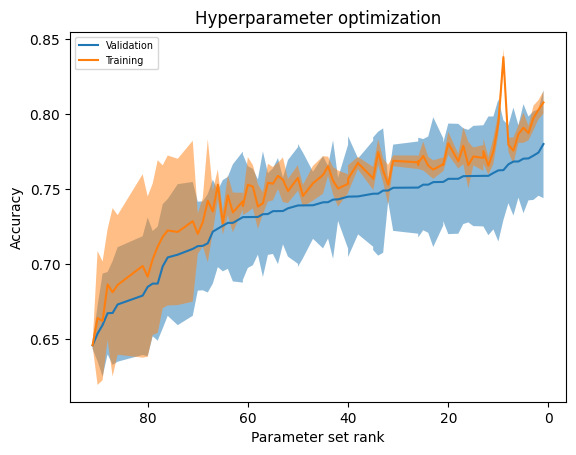

In [13]:
plot_hyperparameter_tuning(round_two_results).show()

In [14]:
# Instantiate a model using the winning parameters
model=GradientBoostingClassifier(
    **round_one_results.best_params_,
    **round_two_results.best_params_,
    random_state=315
)

# Run cross-validation on the best model
scores=cross_val_score(
    model,
    training_features,
    training_labels,
    cv=cv_method,
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
hyperparameter_experiments['Hyperparameter\noptimization\nround 2']=scores * 100
print(f'Cross-validation accuracy: {(np.median(scores) * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 75.7 +/- 3.6%


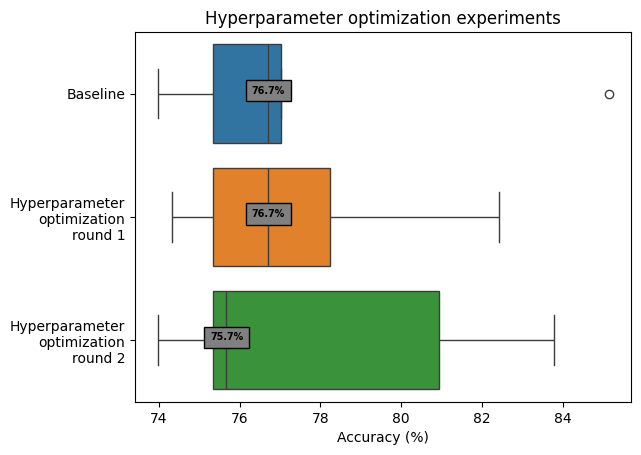

In [15]:
plot_cross_validation('Hyperparameter optimization experiments', hyperparameter_experiments).show()

## 3. Model evaluation

### 3.1. Evaluate the model on test data

In [16]:
# Finally, train the model on all of the training data at once
model=GradientBoostingClassifier(
    **round_one_results.best_params_,
    **round_two_results.best_params_,
    random_state=315
)

fit_result=model.fit(training_features, training_labels)

In [17]:
# Make predictions from test set features
predicted_labels=model.predict(testing_features)

# Score predictions from accuracy
percent_accuracy=accuracy_score(testing_labels, predicted_labels) * 100
print(f'Model is {percent_accuracy:.1f}% accurate on the test data')

Model is 72.8% accurate on the test data


### 3.2. Save the model

In [18]:
# Save the model
model_output_file='../models/gradient_boosting_diabetes_predictor.pkl'

with open(model_output_file, 'wb') as output_file:
    pickle.dump(model, output_file, protocol=pickle.HIGHEST_PROTOCOL)

## 4. Model comparison

Now, let's compare the three models we have built with the diabetes data: decision tree, random forest and gradient boosting.

### 4.1. Load the models

In [19]:
models={
    'model_name': ['Decision tree', 'Random forest', 'Gradient boosting'],
    'model_file': ['decision_tree_diabetes_predictor.pkl', 'random_forest_diabetes_predictor.pkl', 'gradient_boosting_diabetes_predictor.pkl'],
    'models': {}
}

for model_name, model_file in zip(models['model_name'], models['model_file']):

    model_filepath=f'../models/{model_file}'

    with open(model_filepath, 'rb') as input_file:
        models['models'][model_name]=pickle.load(input_file)

### 4.2. Cross-validate the models

In [20]:
model_comparisons={}

for model_name in models['model_name']:

    # Run cross-validation on the best model
    scores=cross_val_score(
        models['models'][model_name],
        training_features,
        training_labels,
        cv=cv_method,
        n_jobs=-1,
        scoring='accuracy'
    )

    model_comparisons[model_name]=scores * 100
    print(f'{model_name} cross-validation accuracy: {(np.median(scores) * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Decision tree cross-validation accuracy: 74.3 +/- 2.7%
Random forest cross-validation accuracy: 70.3 +/- 4.0%
Gradient boosting cross-validation accuracy: 75.7 +/- 3.6%


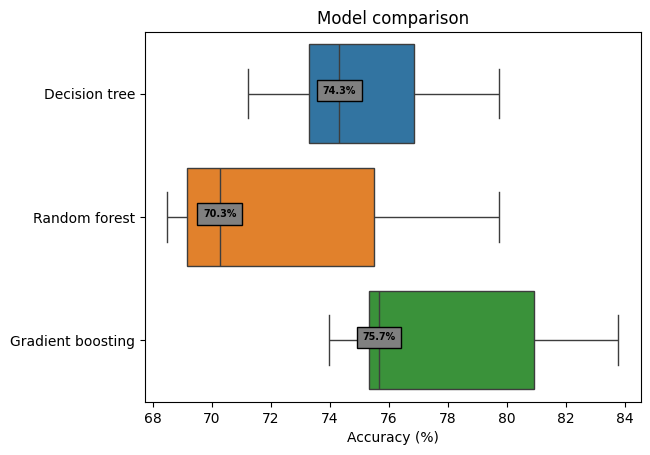

In [21]:
plot_cross_validation('Model comparison', model_comparisons).show()

### 4.2. Evaluate the models on the test data

In [23]:
for model_name in models['model_name']:

    # Make predictions from test set features
    predicted_labels=models['models'][model_name].predict(testing_features)

    # Score predictions from accuracy
    percent_accuracy=accuracy_score(testing_labels, predicted_labels) * 100
    print(f'{model_name} model is {percent_accuracy:.1f}% accurate on the test data')

Decision tree model is 72.0% accurate on the test data
Random forest model is 71.7% accurate on the test data
Gradient boosting model is 72.8% accurate on the test data
